In [1]:
import pandas as pd
import sqlite3
import seaborn as sns

# Establish connection to sqlite db
cnx = sqlite3.connect('bank_churners.db')
customer_churn_df = pd.read_sql_query('SELECT * FROM bank_churners', cnx)

In [2]:
# Check column names
customer_churn_df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [3]:
# Check datatypes
customer_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [4]:
# Check for missing values
customer_churn_df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [5]:
# Drop unnecessary columns
customer_churn_df = customer_churn_df.drop(columns= ['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
print(customer_churn_df.head())
print(customer_churn_df.shape)

      Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      F                3     High School   
1  Attrited Customer            58      M                0         Unknown   
2  Attrited Customer            46      M                3       Doctorate   
3  Existing Customer            34      F                2      Uneducated   
4  Existing Customer            49      F                2      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married  Less than $40K          Blue              36   
1         Single     $40K - $60K          Blue              45   
2       Divorced    $80K - $120K          Blue              38   
3         Single  Less than $40K          Blue              24   
4        Married         Unknown          Blue              41   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         4                       3     

In [6]:
# Check for class imbalance
customer_churn_df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

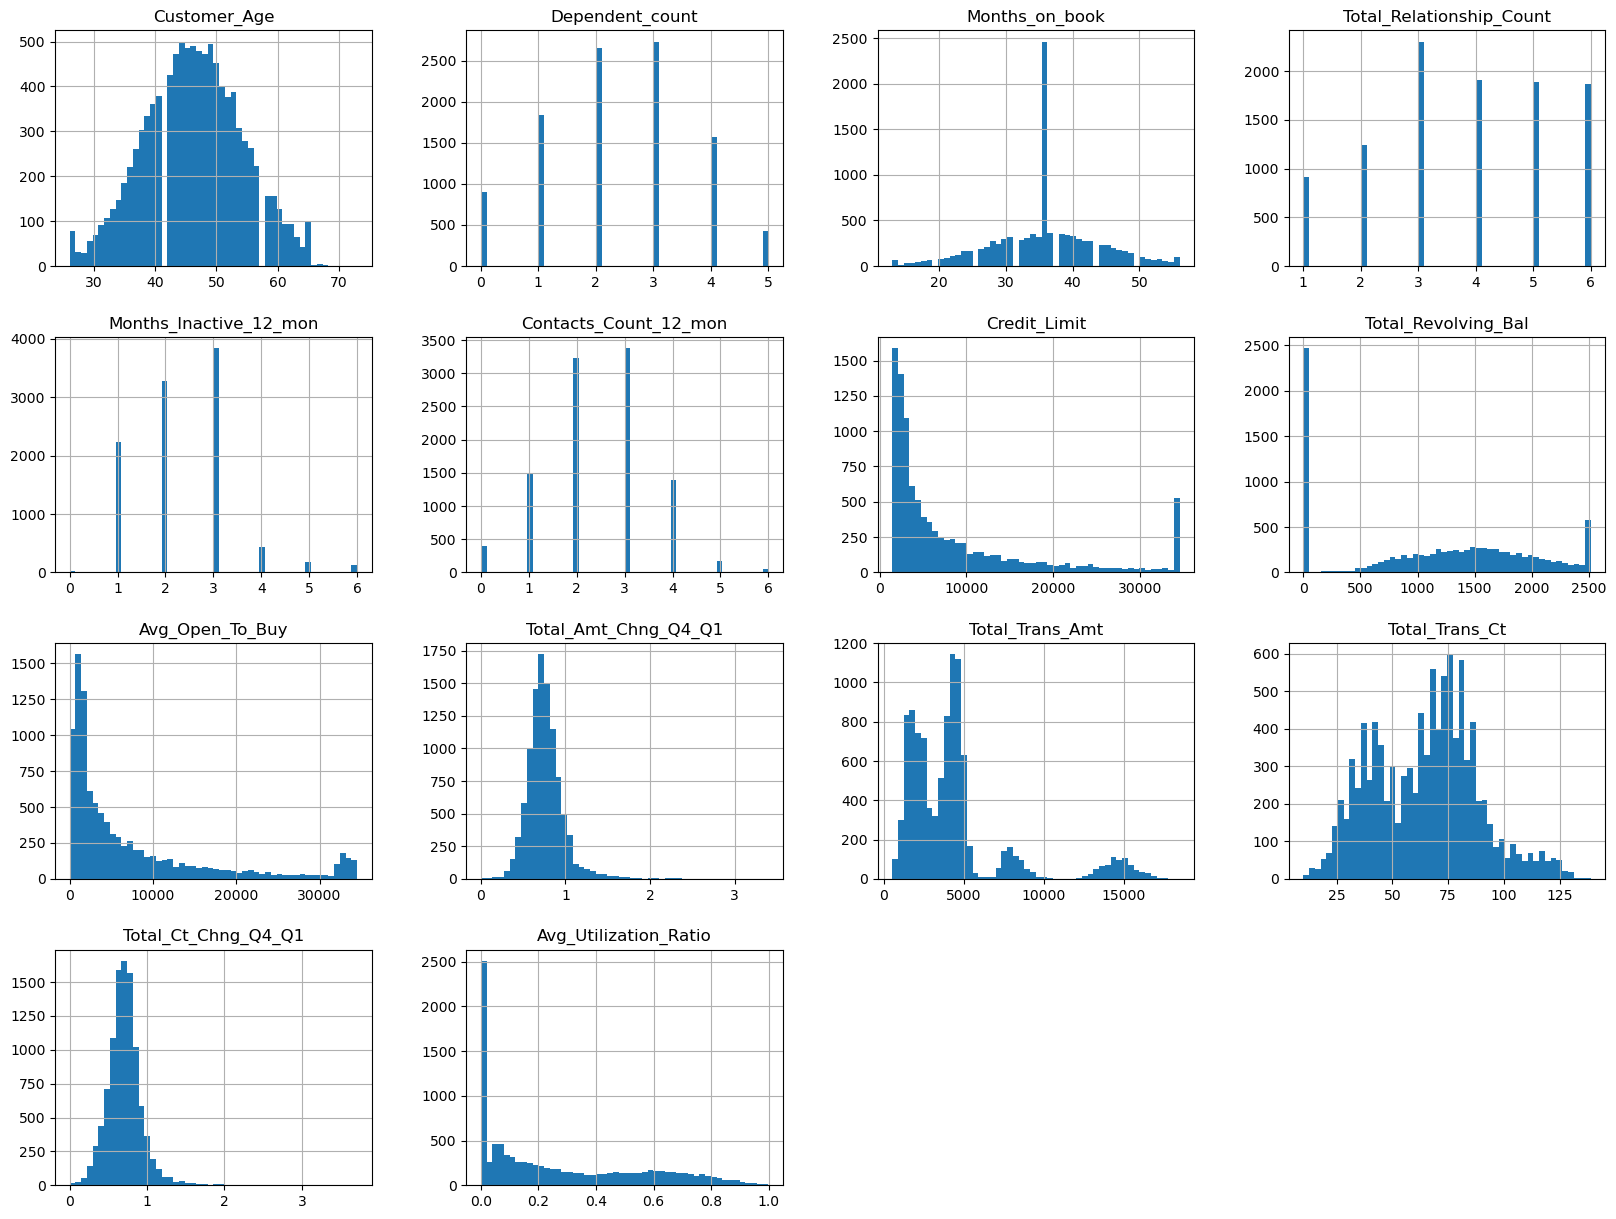

In [7]:
import matplotlib.pyplot as plt

# Plot histograms of numeric columns
customer_churn_df.hist(bins=50, figsize=(20,15))
plt.show()


In [8]:
from scipy import stats
import numpy as np

# Remove outliers using z-score
# Create df with only numeric columns
numeric_cols = customer_churn_df.select_dtypes(include=[np.number]).columns

# Calculate z-score (absolute value)
z_scores = stats.zscore(customer_churn_df[numeric_cols])
abs_z_scores = np.abs(z_scores)

# New df including values with a z-score < 3
filtered_entries = (abs_z_scores < 3).all(axis=1)
customer_churn_df = customer_churn_df[filtered_entries]

# Review filtered df
print(customer_churn_df.head())
print(customer_churn_df.shape)

      Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
1  Attrited Customer            58      M                0         Unknown   
3  Existing Customer            34      F                2      Uneducated   
4  Existing Customer            49      F                2      Uneducated   
5  Existing Customer            43      M                4         Unknown   
7  Existing Customer            37      F                2     High School   

  Marital_Status Income_Category Card_Category  Months_on_book  \
1         Single     $40K - $60K          Blue              45   
3         Single  Less than $40K          Blue              24   
4        Married         Unknown          Blue              41   
5        Unknown         $120K +          Blue              34   
7         Single  Less than $40K          Blue              36   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
1                         3                       1     

In [9]:
# Seperate features from the target variable
y = customer_churn_df['Attrition_Flag']
X = customer_churn_df.drop(columns= ['Attrition_Flag'])

In [10]:
# Preview features data
X.head(3)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1,58,M,0,Unknown,Single,$40K - $60K,Blue,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
3,34,F,2,Uneducated,Single,Less than $40K,Blue,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,49,F,2,Uneducated,Married,Unknown,Blue,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239


In [11]:
# Preview the first five entries for the target variable
y[:5]

1    Attrited Customer
3    Existing Customer
4    Existing Customer
5    Existing Customer
7    Existing Customer
Name: Attrition_Flag, dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le = LabelEncoder()

categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

for feature in categorical_features:
    X[feature] = le.fit_transform(X[feature])

In [13]:
# Replacing 'Existing Customer' with 0 and 'Attrited Customer' with 1 in the 'Attrition_Flag' column
customer_churn_df['Attrition_Flag'] = customer_churn_df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1})

In [14]:
# Review the features data
X.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1,58,1,0,6,2,1,0,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
3,34,0,2,5,2,4,0,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,49,0,2,5,1,5,0,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239
5,43,1,4,6,3,0,0,34,5,2,2,33304.0,1833,31471.0,0.428,1448,29,0.381,0.055
7,37,0,2,3,2,4,0,36,4,2,2,5723.0,1873,3850.0,0.851,2732,63,0.853,0.327


In [15]:
# Review the first five encoded entries for the target variable
y[:5]

1    Attrited Customer
3    Existing Customer
4    Existing Customer
5    Existing Customer
7    Existing Customer
Name: Attrition_Flag, dtype: object

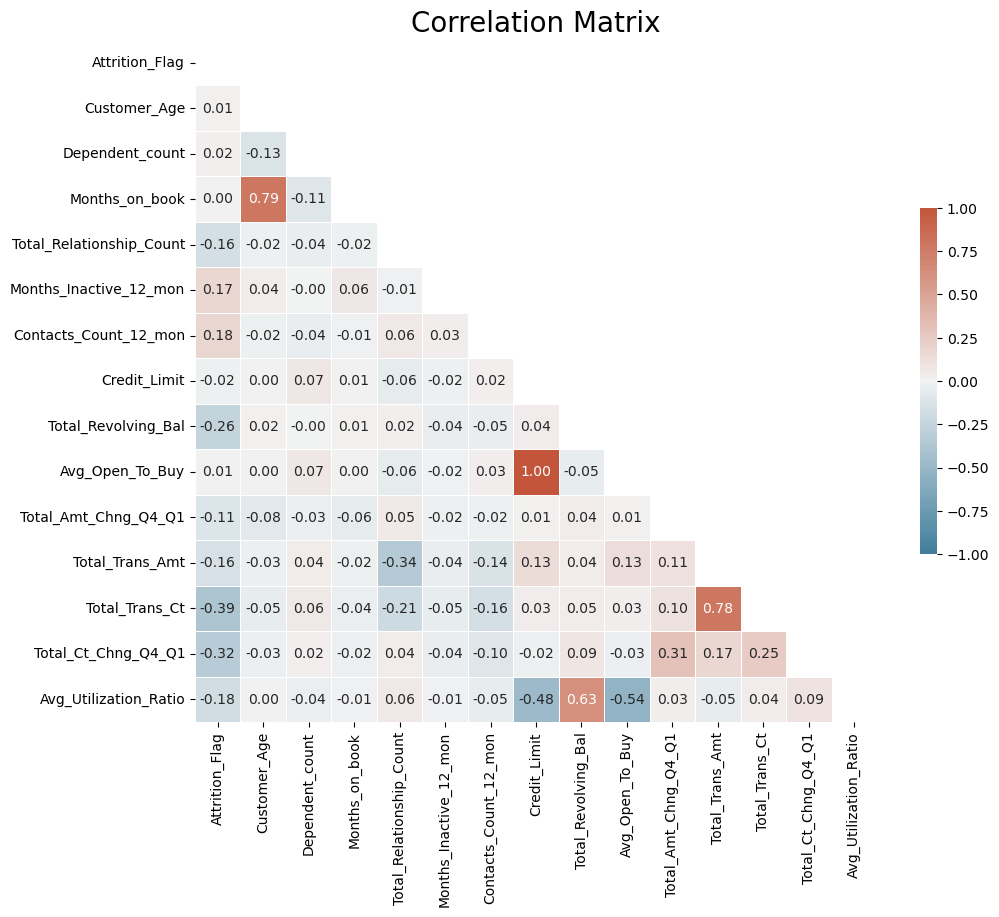

In [16]:
import seaborn as sns

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr = customer_churn_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=78)
rf.fit(X_train_scaled, y_train)

# Logistic Regression
lr = LogisticRegression(solver='lbfgs', random_state=1)
lr.fit(X_train_scaled, y_train)


LogisticRegression(random_state=1)

In [20]:
# Predict the test set results
y_pred_knn = knn.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_lr = lr.predict(X_test_scaled)


# KNN analysis
---

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Classification report for KNN model
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

# Calculating the accuracy score
knn_acc_score = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy Score: {knn_acc_score}')


KNN Classification Report
                   precision    recall  f1-score   support

Attrited Customer       0.78      0.53      0.63       309
Existing Customer       0.91      0.97      0.94      1554

         accuracy                           0.90      1863
        macro avg       0.85      0.75      0.79      1863
     weighted avg       0.89      0.90      0.89      1863

Accuracy Score: 0.8980139559849705


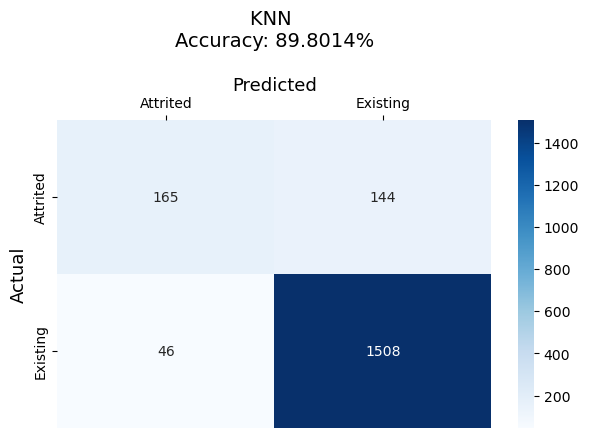

In [22]:
import matplotlib.pyplot as plt

# Create confusion matrix for KNN model
knn_cm = confusion_matrix(y_test, y_pred_knn)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(knn_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Attrited', 'Existing'], yticklabels=['Attrited', 'Existing'])
ax.set_title(f'KNN \nAccuracy: {knn_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Random Forest analysis
---

In [23]:
# Classification report for random forest
print("Random Classification Report")
print(classification_report(y_test, y_pred_rf))

# Calculate the accuracy score
rf_acc_score = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy Score: {rf_acc_score}')

Random Classification Report
                   precision    recall  f1-score   support

Attrited Customer       0.95      0.84      0.89       309
Existing Customer       0.97      0.99      0.98      1554

         accuracy                           0.97      1863
        macro avg       0.96      0.92      0.94      1863
     weighted avg       0.97      0.97      0.97      1863

Accuracy Score: 0.9667203435319377


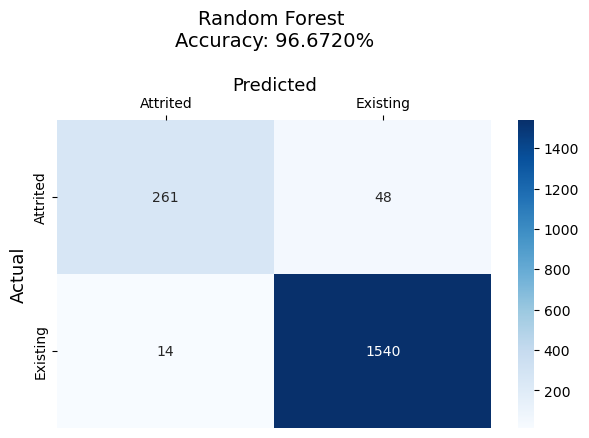

In [24]:
# Create confusion matrix for random forest
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(rf_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Attrited', 'Existing'], yticklabels=['Attrited', 'Existing'])
ax.set_title(f'Random Forest \nAccuracy: {rf_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Optimize Random Forest using feature importance

In [25]:
#Feature importances
importances = rf.feature_importances_

# Sort the features by their importance
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.20640194651528845, 'Total_Trans_Amt'),
 (0.17119322985567162, 'Total_Trans_Ct'),
 (0.10884790787908374, 'Total_Revolving_Bal'),
 (0.09968714381400937, 'Total_Ct_Chng_Q4_Q1'),
 (0.06627854358512064, 'Total_Relationship_Count'),
 (0.0626707311785822, 'Avg_Utilization_Ratio'),
 (0.059628971939898724, 'Total_Amt_Chng_Q4_Q1'),
 (0.034369109473407156, 'Credit_Limit'),
 (0.03253871403979667, 'Customer_Age'),
 (0.03226063690395316, 'Avg_Open_To_Buy'),
 (0.024713628537590973, 'Months_on_book'),
 (0.024655629078544003, 'Months_Inactive_12_mon'),
 (0.01867607291528816, 'Contacts_Count_12_mon'),
 (0.013706529888164872, 'Dependent_count'),
 (0.012158549493576002, 'Education_Level'),
 (0.0114144213360089, 'Income_Category'),
 (0.009270527304585626, 'Marital_Status'),
 (0.009216881151447493, 'Gender'),
 (0.0023108251099822593, 'Card_Category')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

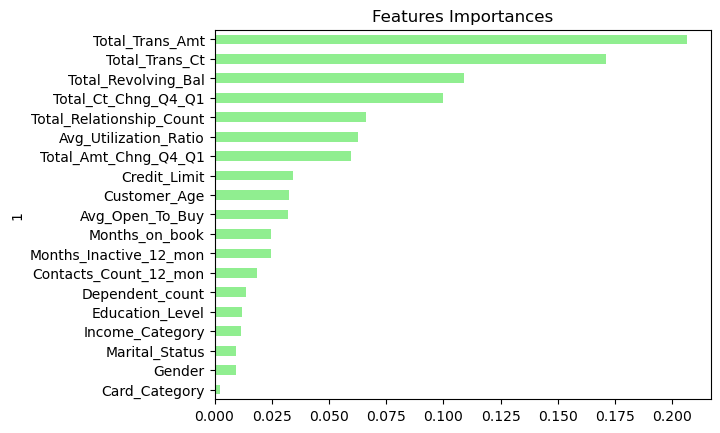

In [26]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Logistic Regression analysis
---

In [27]:
# Classification report for logistic regression model
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

# Calculate the accuracy score
lr_acc_score = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy Score: {lr_acc_score}')

Logistic Regression Classification Report
                   precision    recall  f1-score   support

Attrited Customer       0.75      0.55      0.63       309
Existing Customer       0.91      0.96      0.94      1554

         accuracy                           0.89      1863
        macro avg       0.83      0.76      0.79      1863
     weighted avg       0.89      0.89      0.89      1863

Accuracy Score: 0.8942565754159957


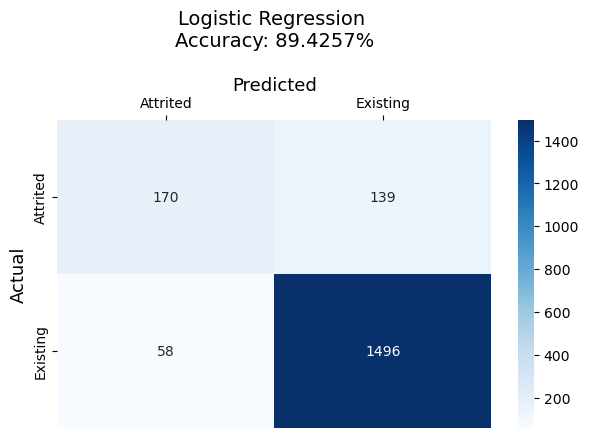

In [28]:
# Create confusion matrix for logistic regression model
lr_cm = confusion_matrix(y_test, y_pred_lr)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(lr_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Attrited', 'Existing'], yticklabels=['Attrited', 'Existing'])
ax.set_title(f'Logistic Regression \nAccuracy: {lr_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Optimize Logistic regression model with adjusted weights

In [29]:
lr_adjusted = LogisticRegression(class_weight='balanced', max_iter=1000)

In [30]:
lr_adjusted.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [31]:
ypred_lr_adj = lr_adjusted.predict(X_test_scaled)

In [32]:
# Classification report for adjusted logistic regression model
print("Logistic Regression Classification Report")
print(classification_report(y_test, ypred_lr_adj))

# Calculate the accuracy score
lr_adj_acc_score = accuracy_score(y_test, ypred_lr_adj)
print(f'Accuracy Score: {lr_adj_acc_score}')

Logistic Regression Classification Report
                   precision    recall  f1-score   support

Attrited Customer       0.52      0.87      0.65       309
Existing Customer       0.97      0.84      0.90      1554

         accuracy                           0.84      1863
        macro avg       0.74      0.85      0.77      1863
     weighted avg       0.89      0.84      0.86      1863

Accuracy Score: 0.8427267847557702


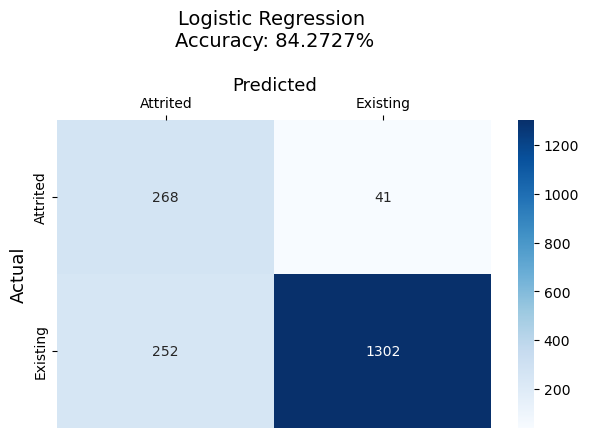

In [33]:
# Create confusion matrix for adjusted weights logistic regression model
lr_adj_cm = confusion_matrix(y_test, ypred_lr_adj)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(lr_adj_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Attrited', 'Existing'], yticklabels=['Attrited', 'Existing'])
ax.set_title(f'Logistic Regression \nAccuracy: {lr_adj_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

## Logistic Regression Model with Resampled Training Data

In [34]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [35]:
# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

Attrited Customer    6222
Existing Customer    6222
Name: Attrition_Flag, dtype: int64

In [36]:
# Instantiate the Logistic Regression model
log_model_resampled = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model using the resampled training data
log_model_resampled.fit(X_train_ros, y_train_ros)

# Make a prediction using the testing data
ros_predictions = log_model_resampled.predict(X_test)

/Users/emilyneaville/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [37]:
from sklearn.metrics import balanced_accuracy_score

# Print the balanced_accuracy score of the model 
log_model_resample_acc = balanced_accuracy_score(y_test, ros_predictions)
log_model_resample_acc

0.820628881308493

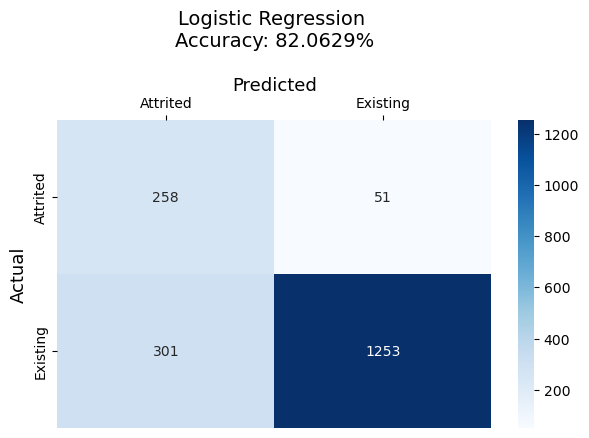

In [38]:
# Generate a confusion matrix for the model
ros_lr_cm = confusion_matrix(y_test, ros_predictions)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(ros_lr_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Attrited', 'Existing'], yticklabels=['Attrited', 'Existing'])
ax.set_title(f'Logistic Regression \nAccuracy: {log_model_resample_acc:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

In [39]:
# Print the classification report for the model
print(classification_report(y_test, ros_predictions))

                   precision    recall  f1-score   support

Attrited Customer       0.46      0.83      0.59       309
Existing Customer       0.96      0.81      0.88      1554

         accuracy                           0.81      1863
        macro avg       0.71      0.82      0.74      1863
     weighted avg       0.88      0.81      0.83      1863

